In [77]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
def f(x):
    return x**2 + 3*x

In [79]:
x = -1.5
h = 0.001
(f(x + h) - f(x)) / h

0.0010000000005838672

In [80]:
#  output = (x-y)*z*w

class Node:
    def __init__(self, data, inputs=(), _operation='', name=''):
        self.data = data
        self.gradient = 0.0
        self._inputs = set(inputs)
        self._operation = _operation
        self.name = name

    def __repr__(self):
        return f"Node(data={self.data})"

    def __mul__(self, other):
        return Node(self.data * other.data, (self, other), '*')

    def __sub__(self, other):
        return Node(self.data - other.data, (self, other), '-')

    def __add__(self, other):
      return Node(self.data + other.data, (self, other), '+')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        return Node(t, (self, ), 'tanh')

x = Node(5.0, name='x')
y = Node(3.0, name='y')
z = Node(2.0, name='z')
w = Node(0.5, name='w')
m = x - y; m.name = 'm'
results = m * z; results.name = 'results'
output = results * w; output.name = 'output'
output


Node(data=2.0)

In [81]:
# visualize
from graphviz import Digraph

def collect_nodes(root):
  all_nodes, all_edges = set(), set()
  def traverse(node):
    if node not in all_nodes:
      all_nodes.add(node)
      for input_node in node._inputs:
        all_edges.add((input_node, node))
        traverse(input_node)
  traverse(root)
  return all_nodes, all_edges

def visualize_graph(root):
  graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  all_nodes, all_edges = collect_nodes(root)
  for node in all_nodes:
    node_id = str(id(node))
    graph.node(name=node_id, label="{ %s | data %.4f | gradient %.4f}" % (node.name, node.data, node.gradient), shape='record')
    if node._operation:
      graph.node(name=node_id + node._operation, label=node._operation)
      graph.edge(node_id + node._operation, node_id)

  for n1, n2 in all_edges:
    graph.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return graph



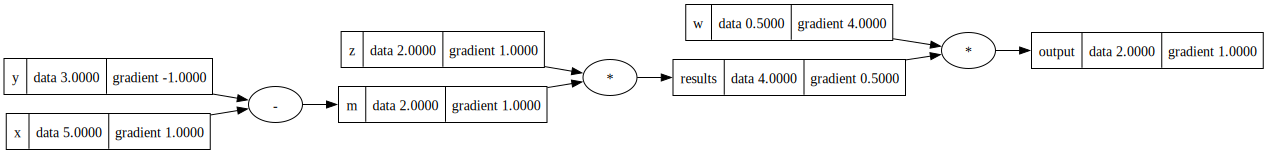

In [82]:
output.gradient = 1.0

w.gradient = results.data
results.gradient = w.data

z.gradient = 1.0
m.gradient = 1.0

# m = x- y
# dm/x = 1, dm/y = -1
x.gradient = m.gradient * 1.0
y.gradient = m.gradient * -1.0

visualize_graph(output)

# One Neuron

In [153]:
# out = tanh(w1x1 + w2x2 + b)

# inputs 
x1 = Node(3.0, name='x1')
x2 = Node(1.0, name='x2')

# weights 
w1 = Node(-2.0, name='w1')
w2 = Node(0.5, name='w2')
b = Node(4, name='b')

# w1x1 + w2x2 + b
w1x1 = w1 * x1; w1x1.name = 'w1*x1'
w2x2 = w2 * x2; w2x2.name = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.name = 'w1*x1 + w2*x2'

y = w1x1w2x2 + b; y.name = 'y'

# activation
out = y.tanh(); out.name = 'out'

# Loss
target = Node(1.0, name = 'target')
# loss = (out- target)**2 = (out-target)*(out-target)
n = (out - target); n.name = 'n'
loss = n*n; loss.name = 'loss'
loss

Node(data=3.6295898683660845)

In [154]:
loss.gradient = 1.0
# dloss/dn1 = n, dloss/n2 = n => dloss/n = 2n
n.gradient = 2 * n.data
# dn/out = 1, dn/target = -1 => 
out.gradient = 1 * n.gradient
# target.gradient = (-1) * n.gradient
# out = tanh(y) 
# dout/y = ? => 1 - out^2
y.gradient = (1-out.data**2) * out.gradient
w1x1w2x2.gradient = y.gradient * 1.0
b.gradient = y.gradient * 1.0

w1x1.gradient = w1x1w2x2.gradient * 1.0
w2x2.gradient = w1x1w2x2.gradient * 1.0

w1.gradient = x1.data * w1x1.gradient
x1.gradient = w1.data * w1x1.gradient

w2.gradient = x2.data * w2x2.gradient
x2.gradient = w2.data * w2x2.gradient

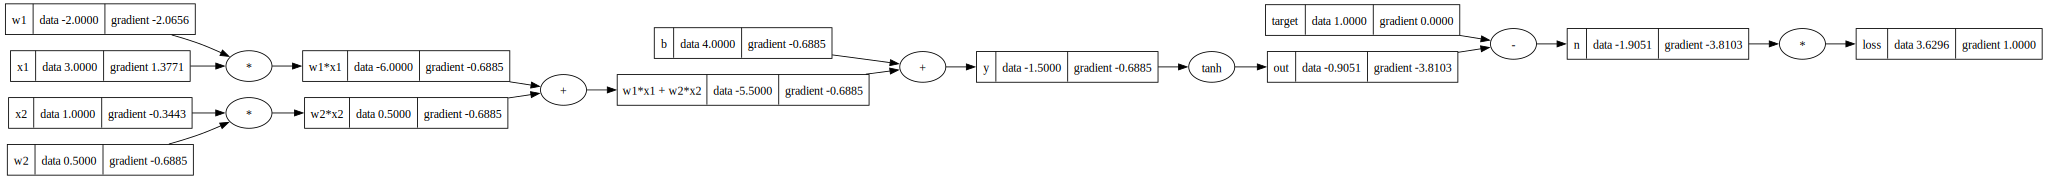

In [155]:
visualize_graph(loss)

In [173]:
# inputs
x1 = Node(3.0, name='x1')
x2 = Node(1.0, name='x2')
w1 = Node(-2.0, name='w1')
w2 = Node(0.5, name='w2')
b = Node(4, name='b')

# target
target = Node(1.0, name='target')

In [174]:
def zero_grad(params):
  for p in params:
    p.gradient = 0.0

In [175]:
lr = 0.1

w1.data -= lr * w1.gradient
w2.data -= lr * w2.gradient
b.data  -= lr * b.gradient

In [ ]:
params = [w1, w2, b]

for step in range(20):

    # 1. zero grad
    zero_grad(params)

    # 2. forward
    w1x1 = w1 * x1
    w2x2 = w2 * x2
    y = w1x1 + w2x2 + b
    out = y.tanh()

    # loss (MSE)
    n = out - target
    loss = n * n

    # 3. backward (manual)
    loss.gradient = 1.0
    n.gradient = 2 * n.data
    out.gradient = n.gradient
    y.gradient = (1 - out.data**2) * out.gradient
    w1.gradient += x1.data * y.gradient
    w2.gradient += x2.data * y.gradient
    b.gradient  += y.gradient

    # 4. update
    for p in params:
        p.data -= lr * p.gradient

    print(f"step {step}, loss = {loss.data}")

step 0, loss = 3.6295898683660845
step 1, loss = 2.659225450806751
step 2, loss = 0.012288393755954946
step 3, loss = 0.010126541688246839
step 4, loss = 0.008619981631006308
step 5, loss = 0.007507505188254166
step 6, loss = 0.006651280568881573
step 7, loss = 0.005971380186562089
step 8, loss = 0.005418141454965029
step 9, loss = 0.00495902866256586
step 10, loss = 0.004571811664628614
step 11, loss = 0.004240772789048488
step 12, loss = 0.003954478256460593
step 13, loss = 0.003704408178491024
step 14, loss = 0.0034840817955093355
step 15, loss = 0.003288480598511861
step 16, loss = 0.0031136571533436413
step 17, loss = 0.0029564633299748516
step 18, loss = 0.002814357412203673
step 19, loss = 0.002685264574050272


In [178]:
out.data

0.9481804614643253